# importing packages

In [1]:
# importing all the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
import sklearn.metrics as sm
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

In [2]:
df = pd.read_csv('dummyinvoice (1).csv')
df

,cust_number,Invoice_No,invoice_create_date,due_in_date,clear_date,Invoice Amount,paid_Amount,status
0,100,INV1,20200203,20200213,14-03-2020 00:00,15000,12500,Partial
1,100,INV1,20200203,20200213,NaN,2500,0,not paid
2,101,INV2,20190726,20190808,01-08-2019 00:00,20000,10000,Partial
3,101,INV2,20190726,20190808,NaN,10000,0,not paid
4,102,INV3,20190306,20190324,18-03-2019 00:00,25000,5000,Partial
...,...,...,...,...,...,...,...,...
698,104,INV315,20191121,20191206,06-12-2019 00:00,55000,45000,Partial
699,104,INV315,20191121,20191206,10-12-2019 00:00,10000,10000,Fully
700,105,INV316,20200118,20200202,28-01-2020 00:00,60000,60000,Fully
701,106,INV317,20190921,20191006,07-11-2019 00:00,65000,4567,Partial


# preprocessing

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 703 entries, 0 to 702
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   cust_number          703 non-null    int64 
 1   Invoice_No           703 non-null    object
 2   invoice_create_date  703 non-null    int64 
 3   due_in_date          703 non-null    int64 
 4   clear_date           619 non-null    object
 5   Invoice Amount       703 non-null    int64 
 6   paid_Amount          703 non-null    int64 
 7   status               703 non-null    object
dtypes: int64(5), object(3)
memory usage: 44.1+ KB


In [4]:
df.isnull().sum()

cust_number             0
Invoice_No              0
invoice_create_date     0
due_in_date             0
clear_date             84
Invoice Amount          0
paid_Amount             0
status                  0
dtype: int64

# Date-Time Conversion

In [5]:
from datetime import datetime

In [6]:
df['clear_date']=pd.to_datetime(df['clear_date'],infer_datetime_format=True,errors='coerce')
df['clear_date'].head()

0   2020-03-14
1          NaT
2   2019-08-01
3          NaT
4   2019-03-18
Name: clear_date, dtype: datetime64[ns]

In [7]:
df['due_in_date']=pd.to_datetime(df['due_in_date'],format='%Y%m%d')
df['due_in_date'].head()

0   2020-02-13
1   2020-02-13
2   2019-08-08
3   2019-08-08
4   2019-03-24
Name: due_in_date, dtype: datetime64[ns]

In [8]:
df['invoice_create_date']=pd.to_datetime(df['invoice_create_date'],format='%Y%m%d')
df['invoice_create_date'].head()

0   2020-02-03
1   2020-02-03
2   2019-07-26
3   2019-07-26
4   2019-03-06
Name: invoice_create_date, dtype: datetime64[ns]

In [9]:
df.head()

,cust_number,Invoice_No,invoice_create_date,due_in_date,clear_date,Invoice Amount,paid_Amount,status
0,100,INV1,2020-02-03,2020-02-13,2020-03-14,15000,12500,Partial
1,100,INV1,2020-02-03,2020-02-13,NaT,2500,0,not paid
2,101,INV2,2019-07-26,2019-08-08,2019-08-01,20000,10000,Partial
3,101,INV2,2019-07-26,2019-08-08,NaT,10000,0,not paid
4,102,INV3,2019-03-06,2019-03-24,2019-03-18,25000,5000,Partial


In [10]:
df.dropna(axis=1,how='all',inplace=True)
df.shape

(703, 8)

In [11]:
df.dropna(axis=0,subset=['Invoice_No'],inplace=True)
df.reset_index(drop=True,inplace=True)
df.shape
df

,cust_number,Invoice_No,invoice_create_date,due_in_date,clear_date,Invoice Amount,paid_Amount,status
0,100,INV1,2020-02-03,2020-02-13,2020-03-14,15000,12500,Partial
1,100,INV1,2020-02-03,2020-02-13,NaT,2500,0,not paid
2,101,INV2,2019-07-26,2019-08-08,2019-08-01,20000,10000,Partial
3,101,INV2,2019-07-26,2019-08-08,NaT,10000,0,not paid
4,102,INV3,2019-03-06,2019-03-24,2019-03-18,25000,5000,Partial
...,...,...,...,...,...,...,...,...
698,104,INV315,2019-11-21,2019-12-06,2019-12-06,55000,45000,Partial
699,104,INV315,2019-11-21,2019-12-06,2019-12-10,10000,10000,Fully
700,105,INV316,2020-01-18,2020-02-02,2020-01-28,60000,60000,Fully
701,106,INV317,2019-09-21,2019-10-06,2019-11-07,65000,4567,Partial


In [12]:
 for cols in df.columns:   
    print(f"{cols} - {df[f'{cols}'].nunique()}")

cust_number - 10
Invoice_No - 317
invoice_create_date - 220
due_in_date - 227
clear_date - 310
Invoice Amount - 78
paid_Amount - 92
status - 4


In [13]:
unique_cols =  [x for x in df.columns if df[x].nunique()==1] 
print(unique_cols)
df.drop(unique_cols,axis=1,inplace=True)
df.columns

[]


Index(['cust_number', 'Invoice_No', 'invoice_create_date', 'due_in_date',
       'clear_date', 'Invoice Amount', 'paid_Amount', 'status'],
      dtype='object')

In [14]:
df.isnull().any()

cust_number            False
Invoice_No             False
invoice_create_date    False
due_in_date            False
clear_date              True
Invoice Amount         False
paid_Amount            False
status                 False
dtype: bool

# Feature engineering

In [15]:
df['delay']=(df['clear_date']-df['due_in_date']).dt.days 

In [16]:
df.head()

,cust_number,Invoice_No,invoice_create_date,due_in_date,clear_date,Invoice Amount,paid_Amount,status,delay
0,100,INV1,2020-02-03,2020-02-13,2020-03-14,15000,12500,Partial,30.0
1,100,INV1,2020-02-03,2020-02-13,NaT,2500,0,not paid,NaN
2,101,INV2,2019-07-26,2019-08-08,2019-08-01,20000,10000,Partial,-7.0
3,101,INV2,2019-07-26,2019-08-08,NaT,10000,0,not paid,NaN
4,102,INV3,2019-03-06,2019-03-24,2019-03-18,25000,5000,Partial,-6.0


In [17]:
df.sort_values(by='invoice_create_date',inplace=True) # sorting in ascending order by create_date
df

,cust_number,Invoice_No,invoice_create_date,due_in_date,clear_date,Invoice Amount,paid_Amount,status,delay
488,101,INV222,2018-12-30,2019-01-14,2019-07-09,15000,15000,Fully,176.0
634,104,INV285,2019-01-03,2019-01-18,2019-01-17,75000,75000,Fully,-1.0
430,107,INV198,2019-01-04,2019-01-19,2019-01-15,65000,65000,Fully,-4.0
22,100,INV11,2019-01-05,2019-01-20,2019-04-18,65000,10000,Partial,88.0
23,100,INV11,2019-01-05,2019-01-20,NaT,55000,0,not paid,NaN
...,...,...,...,...,...,...,...,...,...
51,102,INV23,2020-02-26,2020-03-12,2020-03-09,40000,2000,Partial,-3.0
52,102,INV23,2020-02-26,2020-03-12,2020-03-15,38000,38000,Fully,3.0
149,109,INV70,2020-02-26,2020-03-12,2020-04-29,20000,5000,Partial,48.0
267,103,INV124,2020-02-26,2020-03-12,2020-03-16,35000,35000,Fully,4.0


In [18]:
df['delay'].max

<bound method NDFrame._add_numeric_operations.<locals>.max of 488    176.0
634     -1.0
430     -4.0
22      88.0
23       NaN
       ...  
51      -3.0
52       3.0
149     48.0
267      4.0
150     41.0
Name: delay, Length: 703, dtype: float64>

In [19]:
df.head()

,cust_number,Invoice_No,invoice_create_date,due_in_date,clear_date,Invoice Amount,paid_Amount,status,delay
488,101,INV222,2018-12-30,2019-01-14,2019-07-09,15000,15000,Fully,176.0
634,104,INV285,2019-01-03,2019-01-18,2019-01-17,75000,75000,Fully,-1.0
430,107,INV198,2019-01-04,2019-01-19,2019-01-15,65000,65000,Fully,-4.0
22,100,INV11,2019-01-05,2019-01-20,2019-04-18,65000,10000,Partial,88.0
23,100,INV11,2019-01-05,2019-01-20,NaT,55000,0,not paid,NaN


In [20]:
max_x = df.loc[df['delay'].idxmax()]

In [21]:
min_x = df.loc[df['delay'].idxmin()]

In [22]:
max_x

cust_number                            106
Invoice_No                          INV277
invoice_create_date    2020-02-06 00:00:00
due_in_date            2020-02-21 00:00:00
clear_date             2020-08-21 00:00:00
Invoice Amount                       35000
paid_Amount                          35000
status                               Fully
delay                                182.0
Name: 617, dtype: object

In [23]:
min_x

cust_number                            100
Invoice_No                           INV21
invoice_create_date    2019-09-11 00:00:00
due_in_date            2019-09-26 00:00:00
clear_date             2019-06-24 00:00:00
Invoice Amount                       30000
paid_Amount                           1000
status                             Partial
delay                                -94.0
Name: 45, dtype: object

# rating

In [24]:
# rating=[]
# for i in range(0,len(df)):
#     #if df['delay'][i] <5:
#     if df['delay'][i] >-58 and df['delay'][i]<0:
#         rating.append('excellent')
#     elif df['delay'][i] >0 and df['delay'][i]<5:
#          rating.append('good')
#     elif df['delay'][i] >5 and df['delay'][i]<30:
#         rating.append('low risk')
#     elif df['delay'][i] >30 and df['delay'][i]<60:
#         rating.append('high risk')
#     else:
#         rating.append('risk')

In [25]:
delay=df.loc[:,"delay"].tolist()


In [26]:
rating = []
for i in range(0,len(df)):
    if delay[i]<=0:
#         print(df['delay'][i])
        rating.append("excellent")
    elif delay[i]<=5:
#         print("good",df['delay'][i])
        rating.append("good")
    elif delay[i]<=15:
        rating.append("low risk")
    elif delay[i]<=45:
        rating.append("high risk")
    else:
        rating.append("risk")

In [27]:
df['rating']= rating

In [28]:
df.head()

,cust_number,Invoice_No,invoice_create_date,due_in_date,clear_date,Invoice Amount,paid_Amount,status,delay,rating
488,101,INV222,2018-12-30,2019-01-14,2019-07-09,15000,15000,Fully,176.0,risk
634,104,INV285,2019-01-03,2019-01-18,2019-01-17,75000,75000,Fully,-1.0,excellent
430,107,INV198,2019-01-04,2019-01-19,2019-01-15,65000,65000,Fully,-4.0,excellent
22,100,INV11,2019-01-05,2019-01-20,2019-04-18,65000,10000,Partial,88.0,risk
23,100,INV11,2019-01-05,2019-01-20,NaT,55000,0,not paid,NaN,risk


In [29]:
df.delay.unique

<bound method Series.unique of 488    176.0
634     -1.0
430     -4.0
22      88.0
23       NaN
       ...  
51      -3.0
52       3.0
149     48.0
267      4.0
150     41.0
Name: delay, Length: 703, dtype: float64>

In [30]:
df.rating.unique

<bound method Series.unique of 488         risk
634    excellent
430    excellent
22          risk
23          risk
         ...    
51     excellent
52          good
149         risk
267         good
150    high risk
Name: rating, Length: 703, dtype: object>

# label encoding

In [31]:
#from sklearn import preprocessing

#label_encoder = preprocessing.LabelEncoder()

#df['rating']= label_encoder.fit_transform(df['rating']) 
#df.head()

In [32]:
df1=df.to_csv('rating.csv')

In [33]:
df1=pd.read_csv('rating.csv')

In [34]:
df1.head(10)

,Unnamed: 0,cust_number,Invoice_No,invoice_create_date,due_in_date,clear_date,Invoice Amount,paid_Amount,status,delay,rating
0,488,101,INV222,2018-12-30,2019-01-14,2019-07-09,15000,15000,Fully,176.0,risk
1,634,104,INV285,2019-01-03,2019-01-18,2019-01-17,75000,75000,Fully,-1.0,excellent
2,430,107,INV198,2019-01-04,2019-01-19,2019-01-15,65000,65000,Fully,-4.0,excellent
3,22,100,INV11,2019-01-05,2019-01-20,2019-04-18,65000,10000,Partial,88.0,risk
4,23,100,INV11,2019-01-05,2019-01-20,NaN,55000,0,not paid,NaN,risk
5,556,100,INV251,2019-01-07,2019-01-19,2019-01-24,75000,10000,Partial,5.0,good
6,188,107,INV88,2019-01-07,2019-01-22,2019-01-23,25000,15000,Partial,1.0,good
7,558,100,INV251,2019-01-07,2019-01-19,2019-05-30,55000,55000,Fully,131.0,risk
8,557,100,INV251,2019-01-07,2019-01-19,2019-02-27,65000,10000,Partial,39.0,high risk
9,189,107,INV88,2019-01-07,2019-01-22,2019-01-29,10000,10000,Fully,7.0,low risk


In [35]:
from sklearn import preprocessing

label_encoder = preprocessing.LabelEncoder()

df['rating']= label_encoder.fit_transform(df['rating']) 
df.head()

,cust_number,Invoice_No,invoice_create_date,due_in_date,clear_date,Invoice Amount,paid_Amount,status,delay,rating
488,101,INV222,2018-12-30,2019-01-14,2019-07-09,15000,15000,Fully,176.0,4
634,104,INV285,2019-01-03,2019-01-18,2019-01-17,75000,75000,Fully,-1.0,0
430,107,INV198,2019-01-04,2019-01-19,2019-01-15,65000,65000,Fully,-4.0,0
22,100,INV11,2019-01-05,2019-01-20,2019-04-18,65000,10000,Partial,88.0,4
23,100,INV11,2019-01-05,2019-01-20,NaT,55000,0,not paid,NaN,4


In [36]:
df['invoice_create_date']=pd.to_datetime(df['invoice_create_date'],format='%Y%m%d')
df['invoice_create_date'].head()

488   2018-12-30
634   2019-01-03
430   2019-01-04
22    2019-01-05
23    2019-01-05
Name: invoice_create_date, dtype: datetime64[ns]

In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 703 entries, 488 to 150
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   cust_number          703 non-null    int64         
 1   Invoice_No           703 non-null    object        
 2   invoice_create_date  703 non-null    datetime64[ns]
 3   due_in_date          703 non-null    datetime64[ns]
 4   clear_date           618 non-null    datetime64[ns]
 5   Invoice Amount       703 non-null    int64         
 6   paid_Amount          703 non-null    int64         
 7   status               703 non-null    object        
 8   delay                618 non-null    float64       
 9   rating               703 non-null    int32         
dtypes: datetime64[ns](3), float64(1), int32(1), int64(3), object(2)
memory usage: 73.8+ KB


In [38]:
import datetime as dt
df['invoice_Day'] = pd.DatetimeIndex(df['invoice_create_date']).day
df['invoice_Month'] = pd.DatetimeIndex(df['invoice_create_date']).month
df['due_month'] = pd.DatetimeIndex(df['due_in_date']).month
df['due_date'] = pd.DatetimeIndex(df['due_in_date']).day

In [39]:
df.head()

,cust_number,Invoice_No,invoice_create_date,due_in_date,clear_date,Invoice Amount,paid_Amount,status,delay,rating,invoice_Day,invoice_Month,due_month,due_date
488,101,INV222,2018-12-30,2019-01-14,2019-07-09,15000,15000,Fully,176.0,4,30,12,1,14
634,104,INV285,2019-01-03,2019-01-18,2019-01-17,75000,75000,Fully,-1.0,0,3,1,1,18
430,107,INV198,2019-01-04,2019-01-19,2019-01-15,65000,65000,Fully,-4.0,0,4,1,1,19
22,100,INV11,2019-01-05,2019-01-20,2019-04-18,65000,10000,Partial,88.0,4,5,1,1,20
23,100,INV11,2019-01-05,2019-01-20,NaT,55000,0,not paid,NaN,4,5,1,1,20


# EDA

<AxesSubplot:>

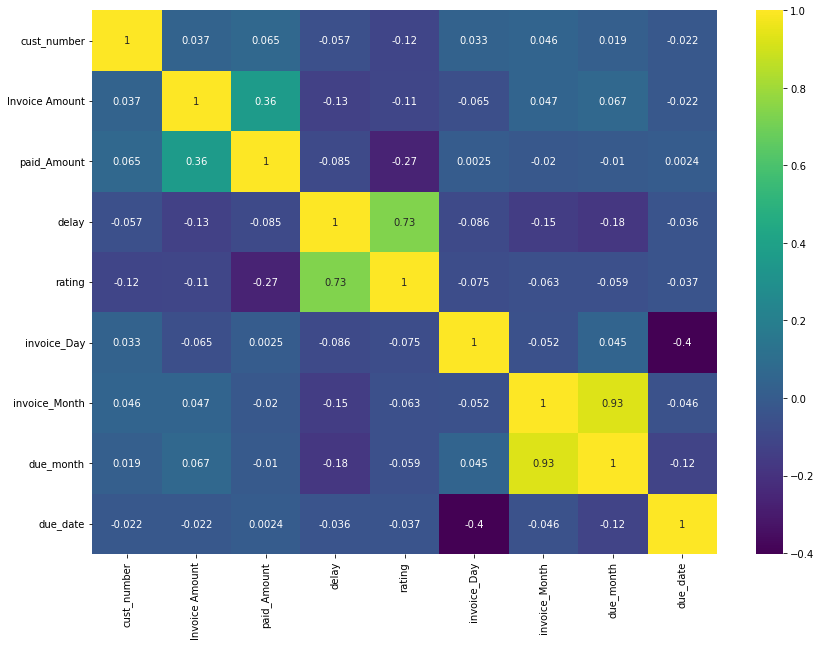

In [40]:
plt.figure(figsize=(14,10))
cor = df.corr()
sns.heatmap(cor,cmap = 'viridis',annot=True)

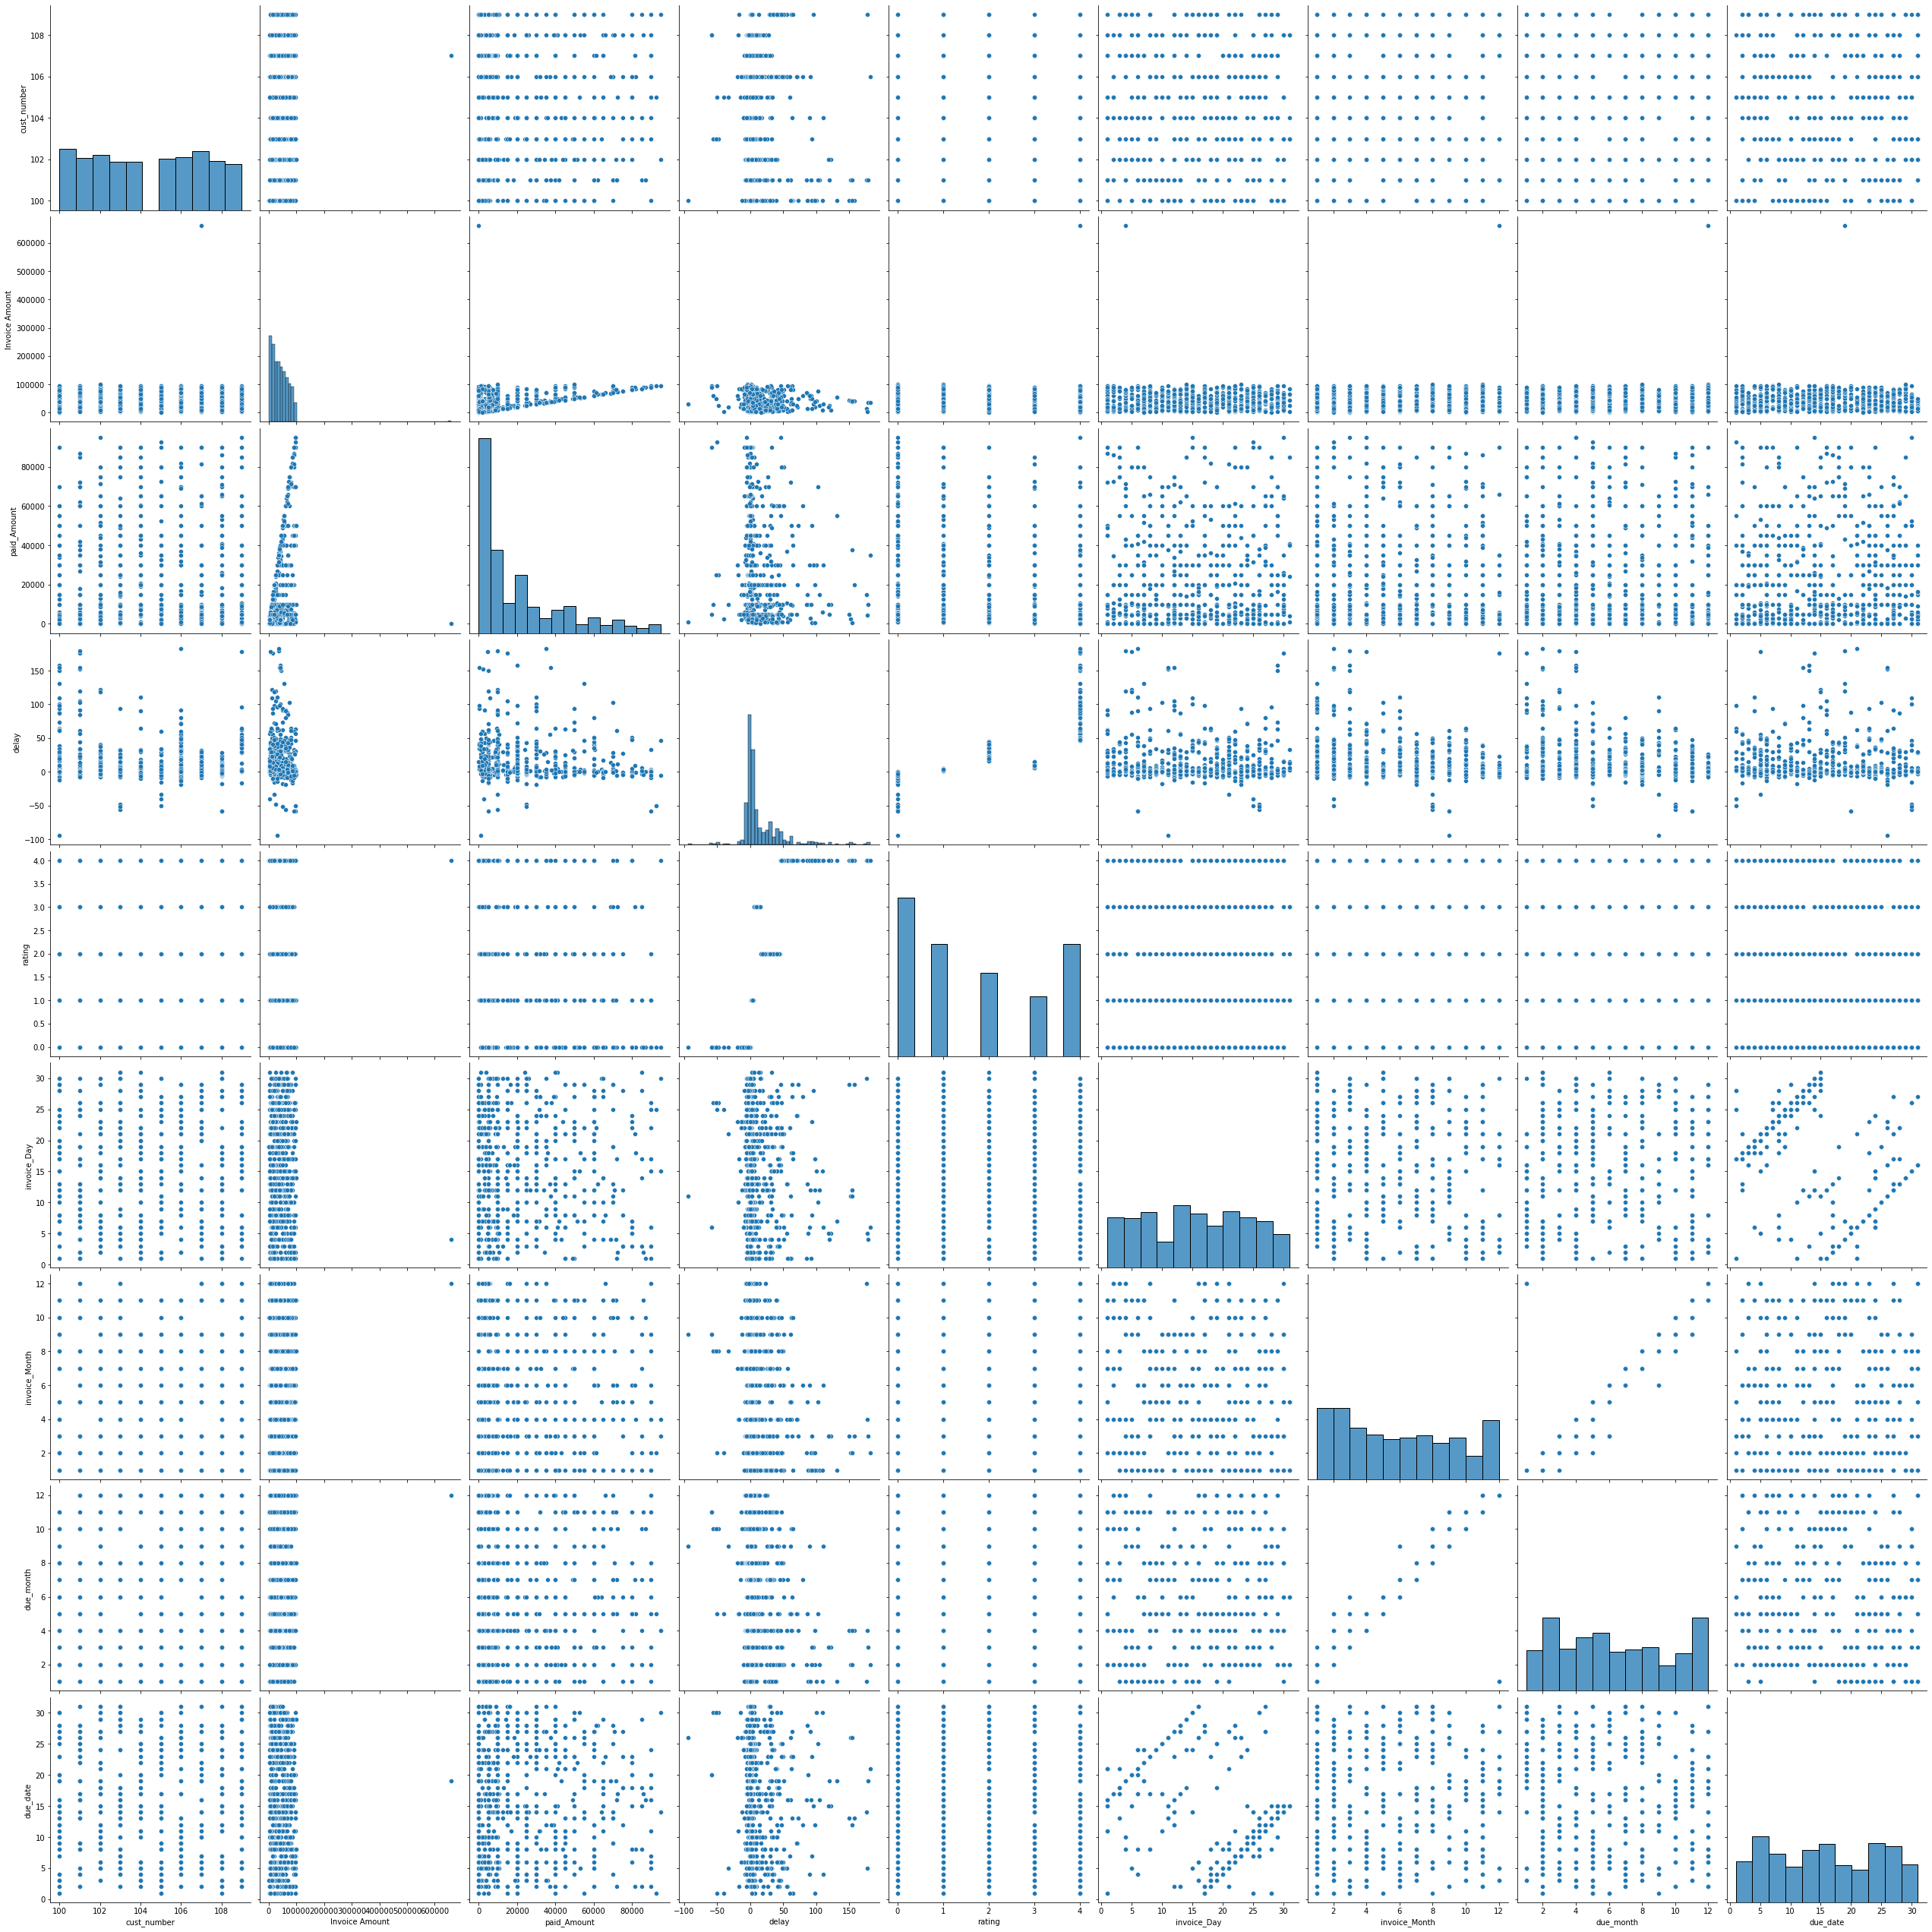

In [41]:
sns.pairplot(df, height=4)

In [42]:
from sklearn import preprocessing

label_encoder = preprocessing.LabelEncoder()

df['status']= label_encoder.fit_transform(df['status']) 
df.head()

,cust_number,Invoice_No,invoice_create_date,due_in_date,clear_date,Invoice Amount,paid_Amount,status,delay,rating,invoice_Day,invoice_Month,due_month,due_date
488,101,INV222,2018-12-30,2019-01-14,2019-07-09,15000,15000,0,176.0,4,30,12,1,14
634,104,INV285,2019-01-03,2019-01-18,2019-01-17,75000,75000,0,-1.0,0,3,1,1,18
430,107,INV198,2019-01-04,2019-01-19,2019-01-15,65000,65000,0,-4.0,0,4,1,1,19
22,100,INV11,2019-01-05,2019-01-20,2019-04-18,65000,10000,1,88.0,4,5,1,1,20
23,100,INV11,2019-01-05,2019-01-20,NaT,55000,0,3,NaN,4,5,1,1,20


In [43]:
import numpy as np
import pandas as pd
import matplotlib as plt
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

C:\Users\Jyothsna.S\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


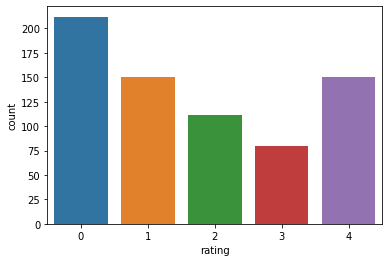

In [44]:
sns.countplot(df['rating'])
plt.show()

In [61]:
X = df.drop(['Invoice_No','invoice_create_date','due_in_date','clear_date','Invoice Amount','paid_Amount','invoice_Day','invoice_Month','due_month','due_date','rating'], axis = 1)
y = df['rating']

In [62]:
X.head()

,cust_number,status,delay
488,101,0,176.0
634,104,0,-1.0
430,107,0,-4.0
22,100,1,88.0
23,100,3,NaN


In [63]:
X['delay'] = X['delay'].fillna(200)

In [64]:
# Splitting the data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=0)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        55
           1       1.00      1.00      1.00        43
           2       1.00      1.00      1.00        23
           3       1.00      1.00      1.00        22
           4       1.00      1.00      1.00        33

    accuracy                           1.00       176
   macro avg       1.00      1.00      1.00       176
weighted avg       1.00      1.00      1.00       176

[[55  0  0  0  0]
 [ 0 43  0  0  0]
 [ 0  0 23  0  0]
 [ 0  0  0 22  0]
 [ 0  0  0  0 33]]
accuracy: 1.0
training accuracy : 1.0
testing accuracy : 1.0


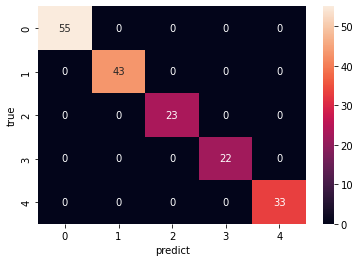

In [65]:
#decision tree
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier
model1 = DecisionTreeClassifier(random_state=1)
model1.fit(X_train, y_train)
y_pred1 = model1.predict(X_test)
print(classification_report(y_test, y_pred1))
cm2=confusion_matrix(y_test,y_pred1)
ax=sns.heatmap(cm2,annot=True)
ax.set(xlabel='predict',ylabel='true')
print(confusion_matrix(y_test, y_pred1))
accuracy1=model1.score(X_test,y_test)
print("accuracy:",accuracy1)
print("training accuracy :", model1.score(X_train, y_train))
print("testing accuracy :", model1.score(X_test, y_test))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        55
           1       0.98      1.00      0.99        43
           2       1.00      1.00      1.00        23
           3       1.00      0.91      0.95        22
           4       0.97      1.00      0.99        33

    accuracy                           0.99       176
   macro avg       0.99      0.98      0.99       176
weighted avg       0.99      0.99      0.99       176

[[55  0  0  0  0]
 [ 0 43  0  0  0]
 [ 0  0 23  0  0]
 [ 0  1  0 20  1]
 [ 0  0  0  0 33]]
accuracy: 0.9886363636363636
training accuracy : 1.0
testing accuracy : 0.9886363636363636


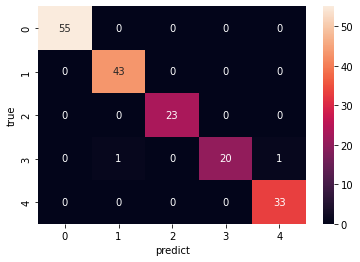

In [66]:
#random forest
from sklearn.ensemble import RandomForestClassifier
model2 = RandomForestClassifier(random_state=1)
model2.fit(X_train, y_train)
y_pred2 = model2.predict(X_test)
print(classification_report(y_test, y_pred2))
cm2=confusion_matrix(y_test,y_pred2)
ax=sns.heatmap(cm2,annot=True)
ax.set(xlabel='predict',ylabel='true')
print(confusion_matrix(y_test, y_pred2))
accuracy2=model2.score(X_test,y_test)
print("accuracy:",accuracy2)
print("training accuracy :", model2.score(X_train, y_train))
print("testing accuracy :", model2.score(X_test, y_test))

In [51]:
# Extract single tree
estimator = model2.estimators_[3]

In [52]:
submission_df = X_test.loc[:, ["cust_number",]]

submission_df['rating'] = y_pred2

#submission_df['id'] = submission_df.id.astype(int)

In [53]:
submission_df.head()

,cust_number,rating
454,107,3
240,102,1
238,100,0
492,103,3
78,103,4


In [54]:
def func(num):
    print(submission_df.loc[submission_df['cust_number']==num].mode())

In [57]:
func(107)

[1]


In [58]:
def func(num):
    output=submission_df.loc[submission_df['cust_number']==num].mode()
    o=output['rating'].tolist()
    print(o)

In [68]:
func(109)

[4]


In [62]:
submission_df.to_csv("prediction_rating.csv")

In [63]:
X_test.head()

,cust_number,status,delay
454,107,1,13.0
240,102,1,1.0
238,100,0,0.0
492,103,1,6.0
78,103,3,200.0


              precision    recall  f1-score   support

           0       0.52      1.00      0.69        55
           1       0.00      0.00      0.00        43
           2       0.81      0.96      0.88        23
           3       0.00      0.00      0.00        22
           4       1.00      0.85      0.92        33

    accuracy                           0.60       176
   macro avg       0.47      0.56      0.50       176
weighted avg       0.46      0.60      0.50       176

[[55  0  0  0  0]
 [43  0  0  0  0]
 [ 0  0 22  1  0]
 [ 7 15  0  0  0]
 [ 0  0  5  0 28]]
accuracy: 0.5965909090909091
training accuracy : 0.6546489563567363
testing accuracy : 0.5965909090909091


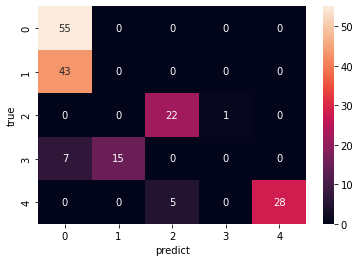

In [64]:
#support vector machine
from sklearn.svm import SVC
model14=SVC(random_state=1)
model14.fit(X_train,y_train)
y_pred14 = model14.predict(X_test)
print(classification_report(y_test, y_pred14))
cm2=confusion_matrix(y_test,y_pred14)
ax=sns.heatmap(cm2,annot=True)
ax.set(xlabel='predict',ylabel='true')
print(confusion_matrix(y_test, y_pred14))
accuracy14=model14.score(X_test,y_test)
print("accuracy:",accuracy14)
print("training accuracy :", model14.score(X_train, y_train))
print("testing accuracy :", model14.score(X_test, y_test))

In [65]:
import pickle
# Saving model to disk of random forest
pickle.dump(model14, open('svm.pkl','wb'))

In [66]:
model=pickle.load(open('svm.pkl', 'rb'))
model.predict([[101,2,176]])

C:\Users\Jyothsna.S\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


array([4])

In [633]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)


In [634]:
from sklearn.svm import SVC
classifier = SVC(kernel = 'linear', random_state = 0)
classifier.fit(X_train, y_train)

SVC(kernel='linear', random_state=0)

In [635]:
y_pred = classifier.predict(X_test)

In [636]:
y_pred

array([1, 0, 0, 1, 4, 0, 0, 0, 2, 4, 0, 0, 0, 0, 2, 0, 2, 0, 2, 0, 0, 4,
       2, 4, 4, 0, 2, 0, 0, 2, 1, 0, 0, 0, 1, 0, 2, 1, 0, 0, 2, 4, 0, 2,
       4, 0, 4, 4, 2, 0, 0, 0, 0, 0, 2, 0, 2, 1, 0, 0, 2, 0, 0, 0, 4, 2,
       0, 2, 0, 0, 0, 0, 0, 4, 2, 0, 0, 0, 0, 0, 1, 4, 0, 1, 0, 0, 0, 0,
       2, 2, 2, 4, 0, 0, 0, 4, 0, 0, 4, 0, 1, 4, 0, 0, 0, 0, 0, 3, 0, 0,
       4, 0, 0, 4, 1, 4, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 4, 0, 2,
       4, 0, 2, 0, 0, 4, 0, 0, 2, 1, 0, 1, 0, 2, 1, 2, 0, 0, 0, 0, 0, 4,
       3, 0, 2, 4, 0, 1, 4, 0, 4, 0, 4, 0, 0, 0, 0, 0, 0, 2, 0, 4, 1, 1])

In [637]:
from sklearn.metrics import confusion_matrix, accuracy_score
cm = confusion_matrix(y_test, y_pred)
print(cm)
accuracy_score(y_test,y_pred)

[[55  0  0  0  0]
 [41  2  0  0  0]
 [ 0  0 22  1  0]
 [ 3 18  0  1  0]
 [ 0  0  5  0 28]]


0.6136363636363636

In [638]:
from sklearn.decomposition import PCA
from sklearn import svm
from sklearn.model_selection import cross_validate
import pylab as pl

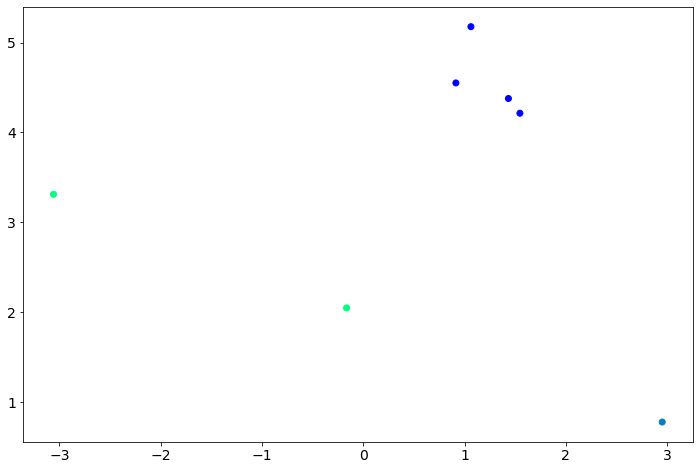

In [639]:
from sklearn.datasets import make_blobs
from sklearn.svm import SVC
X, y = make_blobs(n_samples=10, centers=3, n_features=2,cluster_std=0.60,
                 random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=0)
plt.scatter(X_train[:,0],X_train[:,1],c=y_train,cmap='winter')

In [640]:
from sklearn.svm import SVC
classifier = SVC(kernel = 'linear')
classifier.fit(X_train, y_train)

SVC(kernel='linear')

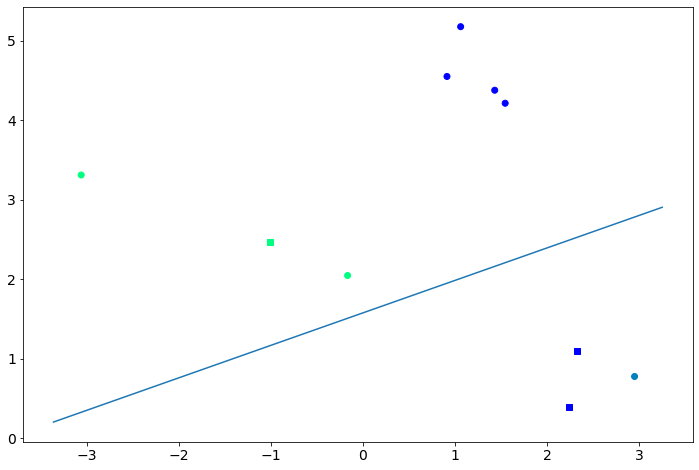

In [641]:
plt.scatter(X_train[:,0],X_train[:,1],c=y_train,cmap='winter')
ax=plt.gca()
xlim=ax.get_xlim()
plt.scatter(X_test[:,0],X_test[:,1],c=y_test,cmap='winter',marker='s')
w=classifier.coef_[0]
a=-w[0]/w[1]
xx=np.linspace(xlim[0],xlim[1])
yy=a * xx - (classifier.intercept_[0] / w[1])
plt.plot(xx,yy)
plt.show()

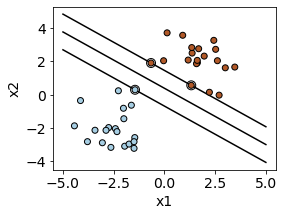

In [642]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm
np.random.seed(2)
# we create 40 linearly separable points
X = np.r_[np.random.randn(20, 2)-[2, 2], np.random.randn(20, 2) + [2, 2]]
Y = [0] * 20 + [1] * 20
# fit the model
clf = svm.SVC(kernel='linear', C=1)
clf.fit(X, Y)
# get the separating hyperplane
w = clf.coef_[0]
a = -w[0] / w[1]
xx = np.linspace(-5, 5)
yy = a * xx-(clf.intercept_[0]) / w[1]
margin = 1 / np.sqrt(np.sum(clf.coef_ ** 2))
yy_down = yy - np.sqrt(1 + a ** 2) * margin
yy_up = yy + np.sqrt(1 + a ** 2) * margin
plt.figure(1, figsize=(4, 3))
plt.clf()
plt.plot(xx, yy, "k-")
plt.plot(xx, yy_down, "k-")
plt.plot(xx, yy_up, "k-")
plt.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1], s=80,
 facecolors="none", zorder=10, edgecolors="k")
plt.scatter(X[:, 0], X[:, 1], c=Y, zorder=10, cmap=plt.cm.Paired,
 edgecolors="k")
plt.xlabel("x1")
plt.ylabel("x2")
plt.show()

# Model building

In [643]:
X = df.drop(['Invoice_No','invoice_create_date','due_in_date','clear_date','Invoice Amount','paid_Amount','invoice_Day','invoice_Month','due_month','due_date','rating'], axis = 1)
y = df['rating']

In [644]:
from sklearn import preprocessing

label_encoder = preprocessing.LabelEncoder()

df['Invoice_No']= label_encoder.fit_transform(df['Invoice_No']) 
df.head()

,cust_number,Invoice_No,invoice_create_date,due_in_date,clear_date,Invoice Amount,paid_Amount,status,delay,rating,invoice_Day,invoice_Month,due_month,due_date
488,101,137,2018-12-30,2019-01-14,2019-07-09,15000,15000,0,176.0,4,30,12,1,14
634,104,206,2019-01-03,2019-01-18,2019-01-17,75000,75000,0,-1.0,0,3,1,1,18
430,107,109,2019-01-04,2019-01-19,2019-01-15,65000,65000,0,-4.0,0,4,1,1,19
22,100,12,2019-01-05,2019-01-20,2019-04-18,65000,10000,1,88.0,4,5,1,1,20
23,100,12,2019-01-05,2019-01-20,NaT,55000,0,3,NaN,4,5,1,1,20


In [645]:
X = df.drop(['invoice_create_date','due_in_date','clear_date'], axis = 1)
y = df['rating']

In [646]:
X['delay'] = X['delay'].fillna(200)

In [647]:
X.head()

,cust_number,Invoice_No,Invoice Amount,paid_Amount,status,delay,rating,invoice_Day,invoice_Month,due_month,due_date
488,101,137,15000,15000,0,176.0,4,30,12,1,14
634,104,206,75000,75000,0,-1.0,0,3,1,1,18
430,107,109,65000,65000,0,-4.0,0,4,1,1,19
22,100,12,65000,10000,1,88.0,4,5,1,1,20
23,100,12,55000,0,3,200.0,4,5,1,1,20


In [648]:
# Splitting the data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=0)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        55
           1       1.00      1.00      1.00        43
           2       1.00      1.00      1.00        23
           3       1.00      1.00      1.00        22
           4       1.00      1.00      1.00        33

    accuracy                           1.00       176
   macro avg       1.00      1.00      1.00       176
weighted avg       1.00      1.00      1.00       176

[[55  0  0  0  0]
 [ 0 43  0  0  0]
 [ 0  0 23  0  0]
 [ 0  0  0 22  0]
 [ 0  0  0  0 33]]
accuracy: 1.0
training accuracy : 1.0
testing accuracy : 1.0


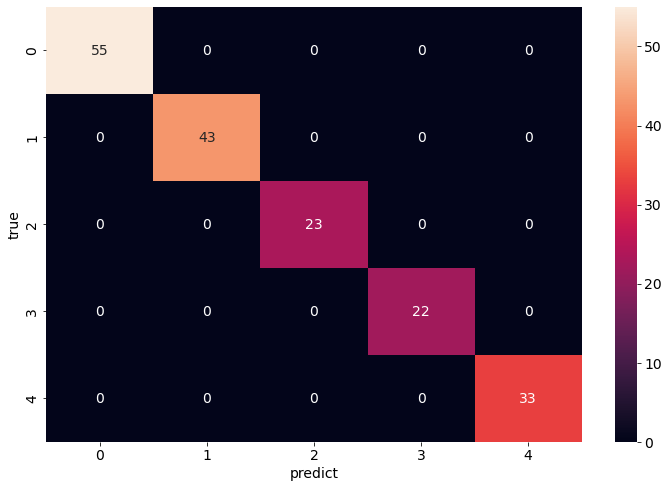

In [649]:
#decision tree
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier
model1 = DecisionTreeClassifier(random_state=1)
model1.fit(X_train, y_train)
y_pred1 = model1.predict(X_test)
print(classification_report(y_test, y_pred1))
cm2=confusion_matrix(y_test,y_pred1)
ax=sns.heatmap(cm2,annot=True)
ax.set(xlabel='predict',ylabel='true')
print(confusion_matrix(y_test, y_pred1))
accuracy1=model1.score(X_test,y_test)
print("accuracy:",accuracy1)
print("training accuracy :", model1.score(X_train, y_train))
print("testing accuracy :", model1.score(X_test, y_test))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        55
           1       1.00      1.00      1.00        43
           2       1.00      1.00      1.00        23
           3       1.00      0.95      0.98        22
           4       0.97      1.00      0.99        33

    accuracy                           0.99       176
   macro avg       0.99      0.99      0.99       176
weighted avg       0.99      0.99      0.99       176

[[55  0  0  0  0]
 [ 0 43  0  0  0]
 [ 0  0 23  0  0]
 [ 0  0  0 21  1]
 [ 0  0  0  0 33]]
accuracy: 0.9943181818181818
training accuracy : 1.0
testing accuracy : 0.9943181818181818


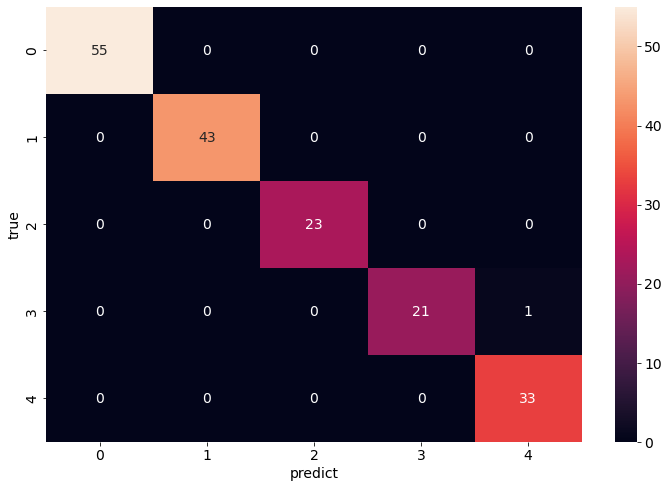

In [650]:
#random forest
from sklearn.ensemble import RandomForestClassifier
model2 = RandomForestClassifier(random_state=1)
model2.fit(X_train, y_train)
y_pred2 = model2.predict(X_test)
print(classification_report(y_test, y_pred2))
cm2=confusion_matrix(y_test,y_pred2)
ax=sns.heatmap(cm2,annot=True)
ax.set(xlabel='predict',ylabel='true')
print(confusion_matrix(y_test, y_pred2))
accuracy2=model2.score(X_test,y_test)
print("accuracy:",accuracy2)
print("training accuracy :", model2.score(X_train, y_train))
print("testing accuracy :", model2.score(X_test, y_test))

              precision    recall  f1-score   support

           0       0.37      0.67      0.48        55
           1       0.27      0.07      0.11        43
           2       0.00      0.00      0.00        23
           3       0.00      0.00      0.00        22
           4       0.33      0.67      0.44        33

    accuracy                           0.35       176
   macro avg       0.20      0.28      0.21       176
weighted avg       0.25      0.35      0.26       176

[[37  4  0  0 14]
 [24  3  0  0 16]
 [14  3  0  0  6]
 [14  0  0  0  8]
 [10  1  0  0 22]]
accuracy: 0.3522727272727273
training accuracy : 0.3700189753320683
testing accuracy : 0.3522727272727273


C:\Users\Jyothsna.S\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Jyothsna.S\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Jyothsna.S\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


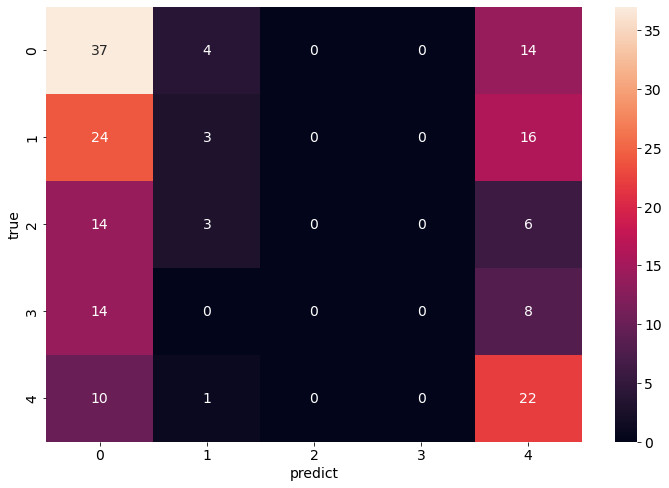

In [651]:
#support vector machine
from sklearn.svm import SVC
model14=SVC(random_state=1)
model14.fit(X_train,y_train)
y_pred14 = model14.predict(X_test)
print(classification_report(y_test, y_pred14))
cm2=confusion_matrix(y_test,y_pred14)
ax=sns.heatmap(cm2,annot=True)
ax.set(xlabel='predict',ylabel='true')
print(confusion_matrix(y_test, y_pred14))
accuracy14=model14.score(X_test,y_test)
print("accuracy:",accuracy14)
print("training accuracy :", model14.score(X_train, y_train))
print("testing accuracy :", model14.score(X_test, y_test))

In [75]:
!pip install dtreeviz

In [652]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from dtreeviz.trees import dtreeviz # will be used for tree visualization
from matplotlib import pyplot as plt
plt.rcParams.update({'figure.figsize': (12.0, 8.0)})
plt.rcParams.update({'font.size': 14})

In [653]:
rf = RandomForestClassifier(n_estimators=100)
rf.fit(X, y)

RandomForestClassifier()

In [654]:
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

RandomForestClassifier(criterion='mse', max_features='auto')

In [655]:
len(rf.estimators_)

100

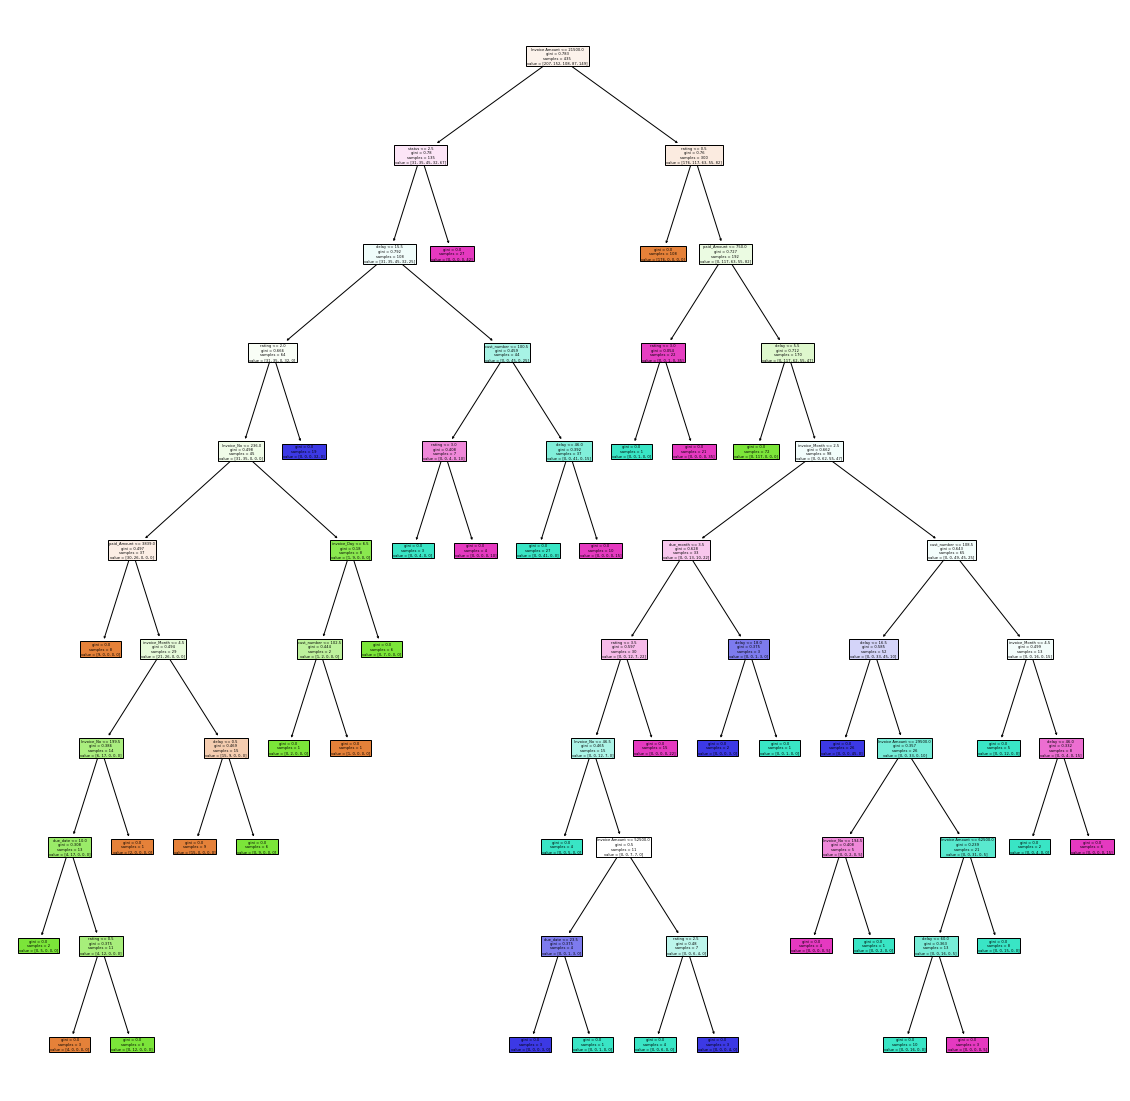

In [656]:
plt.figure(figsize=(20,20))
_ = tree.plot_tree(rf.estimators_[0], feature_names=X.columns, filled=True)

In [657]:
rf.estimators_[0].tree_.max_depth

10

In [658]:
rf = RandomForestClassifier(n_estimators=100, max_depth=3)
rf.fit(X, y)

RandomForestClassifier(max_depth=3)

In [659]:
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=3, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

RandomForestClassifier(criterion='mse', max_depth=3, max_features='auto')

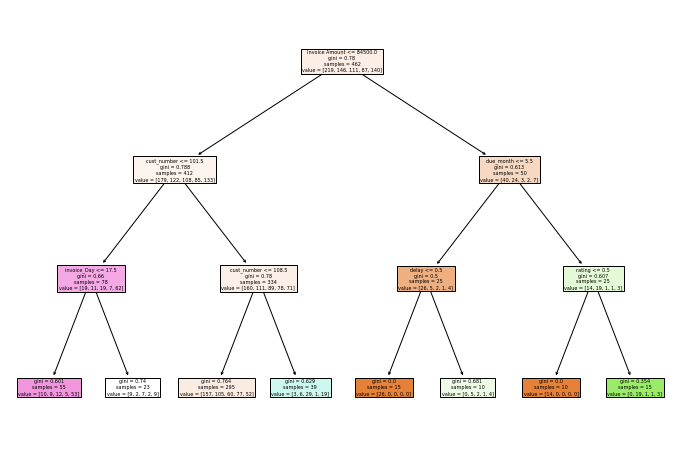

In [660]:
_ = tree.plot_tree(rf.estimators_[0], feature_names=X.columns, filled=True)